## EXPLORATION DE DONNEES & GENERATION MODEL
### Détection d'anomalies KDDCup99

In [4]:
from utils import *

In [5]:
kddcup = pd.read_csv('../data/KDDCup99.csv',sep=',')
kddcup.info(), kddcup.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494020 non-null  int64  
 1   protocol_type                494020 non-null  object 
 2   service                      494020 non-null  object 
 3   flag                         494020 non-null  object 
 4   src_bytes                    494020 non-null  int64  
 5   dst_bytes                    494020 non-null  int64  
 6   land                         494020 non-null  int64  
 7   wrong_fragment               494020 non-null  int64  
 8   urgent                       494020 non-null  int64  
 9   hot                          494020 non-null  int64  
 10  num_failed_logins            494020 non-null  int64  
 11  logged_in                    494020 non-null  int64  
 12  lnum_compromised             494020 non-null  int64  
 13 

(None,
    duration protocol_type service flag  src_bytes  dst_bytes  land  \
 0         0           tcp    http   SF        181       5450     0   
 1         0           tcp    http   SF        239        486     0   
 2         0           tcp    http   SF        235       1337     0   
 
    wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
 0               0       0    0  ...                   9   
 1               0       0    0  ...                  19   
 2               0       0    0  ...                  29   
 
    dst_host_same_srv_rate  dst_host_diff_srv_rate  \
 0                     1.0                     0.0   
 1                     1.0                     0.0   
 2                     1.0                     0.0   
 
    dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
 0                         0.11                          0.0   
 1                         0.05                          0.0   
 2                         0.03                        

In [6]:
kddcup['label'].unique()

array(['normal', 'buffer_overflow', 'loadmodule', 'perl', 'neptune',
       'smurf', 'guess_passwd', 'pod', 'teardrop', 'portsweep', 'ipsweep',
       'land', 'ftp_write', 'back', 'imap', 'satan', 'phf', 'nmap',
       'multihop', 'warezmaster', 'warezclient', 'spy', 'rootkit'],
      dtype=object)

In [7]:
kddcup['label'] = np.where(kddcup['label'] == 'normal', 0, 1)

In [8]:
X = kddcup.drop(columns=['label'])
Y = kddcup['label']

In [9]:
taille_echantillon=int(np.sum(Y==0)*0.03)

In [10]:
X_anomalie = X[Y == 1]
Y_anomalie = Y[Y == 1]
idx = np.random.randint(len(X_anomalie), size=taille_echantillon)
X_anomalie = X_anomalie.iloc[idx]
Y_anomalie = Y_anomalie.iloc[idx]

In [11]:
X_normal = X[Y==0]
Y_normal = Y[Y==0]

In [12]:
X_final = pd.concat([X_normal, X_anomalie], axis=0)
Y_final = pd.concat([Y_normal, Y_anomalie], axis=0)
X_final.shape

(100195, 41)

In [13]:
n_samples, anomaly_frac = X_final.shape[0], Y_final.mean()
print(f"{n_samples} datapoints with {Y_final.sum()} anomalies ({anomaly_frac:.02%})")

100195 datapoints with 2918 anomalies (2.91%)


In [14]:
X_final_encoded = pd.get_dummies(X_final, columns=['protocol_type', 'service', 'flag'])

In [15]:
X_kdd_train, X_kdd_test, Y_kdd_train, Y_kdd_test = train_test_split(X_final_encoded, Y_final, test_size=0.1, stratify=Y_final, random_state=42)

In [16]:
X_kdd_train.columns, X_kdd_test.columns

(Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
        'urgent', 'hot', 'num_failed_logins', 'logged_in', 'lnum_compromised',
        'lroot_shell', 'lsu_attempted', 'lnum_root', 'lnum_file_creations',
        'lnum_shells', 'lnum_access_files', 'lnum_outbound_cmds',
        'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
        'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
        'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
        'dst_host_srv_count', 'dst_host_same_srv_rate',
        'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
        'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate', 'protocol_type_icmp', 'protocol_type_tcp',
        'protocol_type_udp', 'service_IRC', 'service_X11', 'service_auth',
        'service_csnet_ns', 'service_daytime', 'service_domain',
        'service_doma

In [17]:
from objects.Strategy import Strategy
from objects.Scaler import Scaler
from objects.Anomaly import AnomalyType
from objects.Model import ModelType

MinMax = Scaler.MINMAX.value
Robust = Scaler.ROBUST.value

X_train_kdd_minmax, X_test_kdd_minmax = MinMax.fit_transform(X_kdd_train), MinMax.transform(X_kdd_test)
X_train_kdd_robust, X_test_kdd_robust = Robust.fit_transform(X_kdd_train), Robust.transform(X_kdd_test)

strategies_kdd = {
    1: Strategy(name="LR balanced", model_type=ModelType.LOGISTIC_REGRESSION, anomaly_type=AnomalyType.NONE, X_train=X_kdd_train, y_train=Y_kdd_train, X_test=X_kdd_test, params={'random_state':1}),
    2: Strategy(name="LR SMOTE", model_type=ModelType.LOGISTIC_REGRESSION, anomaly_type=AnomalyType.SMOTE, X_train=X_kdd_train, y_train=Y_kdd_train, X_test=X_kdd_test, params={'random_state':1}),
    3: Strategy(name="LR TOMEK", model_type=ModelType.LOGISTIC_REGRESSION, anomaly_type=AnomalyType.TOMEK, X_train=X_kdd_train, y_train=Y_kdd_train, X_test=X_kdd_test, params={'random_state':1}),
    4: Strategy(name="LR balanced", model_type=ModelType.LOGISTIC_REGRESSION, anomaly_type=AnomalyType.NONE, X_train=X_kdd_train, y_train=Y_kdd_train, X_test=X_kdd_test, params={'random_state':1, 'class_weight':'balanced'}),
    5: Strategy(name="RF Base", model_type=ModelType.RANDOM_FOREST, anomaly_type=AnomalyType.NONE, X_train=X_kdd_train, y_train=Y_kdd_train, X_test=X_kdd_test, params={'random_state':1}),
    6: Strategy(name="RF SMOTE", model_type=ModelType.RANDOM_FOREST, anomaly_type=AnomalyType.SMOTE, X_train=X_kdd_train, y_train=Y_kdd_train, X_test=X_kdd_test, params={'random_state':1}),
    7: Strategy(name="RF TOMEK", model_type=ModelType.RANDOM_FOREST, anomaly_type=AnomalyType.TOMEK, X_train=X_kdd_train, y_train=Y_kdd_train, X_test=X_kdd_test, params={'random_state':1}),
    8: Strategy(name="RF balanced", model_type=ModelType.RANDOM_FOREST, anomaly_type=AnomalyType.NONE, X_train=X_kdd_train, y_train=Y_kdd_train, X_test=X_kdd_test, params={'random_state':1, 'class_weight':'balanced'}),
    9: Strategy(name="IF", model_type=ModelType.ISOLATION_FOREST, anomaly_type=AnomalyType.NONE, X_train=X_kdd_train, y_train=Y_kdd_train, X_test=X_kdd_test, params={'n_estimators':1000, 'n_jobs':-1, 'random_state':1}),
    10: Strategy(name="LOF", model_type=ModelType.LOCAL_OUTLIER_FACTOR, anomaly_type=AnomalyType.NONE, X_train=X_kdd_train, y_train=Y_kdd_train, X_test=X_kdd_test, params={'novelty':True, 'n_neighbors':200, 'n_jobs':-1}),

    11: Strategy(name="LR Base MinMax", model_type=ModelType.LOGISTIC_REGRESSION, anomaly_type=AnomalyType.NONE, X_train=X_train_kdd_minmax, y_train=Y_kdd_train, X_test=X_test_kdd_minmax, params={'random_state':1}),
    12: Strategy(name="LR SMOTE MinMax", model_type=ModelType.LOGISTIC_REGRESSION, anomaly_type=AnomalyType.SMOTE, X_train=X_train_kdd_minmax, y_train=Y_kdd_train, X_test=X_test_kdd_minmax, params={'random_state':1}),
    13: Strategy(name="LR TOMEK MinMax", model_type=ModelType.LOGISTIC_REGRESSION, anomaly_type=AnomalyType.TOMEK, X_train=X_train_kdd_minmax, y_train=Y_kdd_train, X_test=X_test_kdd_minmax, params={'random_state':1}),
    14: Strategy(name="LR balanced MinMax", model_type=ModelType.LOGISTIC_REGRESSION, anomaly_type=AnomalyType.NONE, X_train=X_train_kdd_minmax, y_train=Y_kdd_train, X_test=X_test_kdd_minmax, params={'random_state':1, 'class_weight':'balanced'}),
    15: Strategy(name="RF Base MinMax", model_type=ModelType.RANDOM_FOREST, anomaly_type=AnomalyType.NONE, X_train=X_train_kdd_minmax, y_train=Y_kdd_train, X_test=X_test_kdd_minmax, params={'random_state':1}),
    16: Strategy(name="RF SMOTE MinMax", model_type=ModelType.RANDOM_FOREST, anomaly_type=AnomalyType.SMOTE, X_train=X_train_kdd_minmax, y_train=Y_kdd_train, X_test=X_test_kdd_minmax, params={'random_state':1}),
    17: Strategy(name="RF TOMEK MinMax", model_type=ModelType.RANDOM_FOREST, anomaly_type=AnomalyType.TOMEK, X_train=X_train_kdd_minmax, y_train=Y_kdd_train, X_test=X_test_kdd_minmax, params={'random_state':1}),
    18: Strategy(name="RF balanced MinMax", model_type=ModelType.RANDOM_FOREST, anomaly_type=AnomalyType.NONE, X_train=X_train_kdd_minmax, y_train=Y_kdd_train, X_test=X_test_kdd_minmax, params={'random_state':1, 'class_weight':'balanced'}),
    19: Strategy(name="IF MinMax", model_type=ModelType.ISOLATION_FOREST, anomaly_type=AnomalyType.NONE, X_train=X_train_kdd_minmax, y_train=Y_kdd_train, X_test=X_test_kdd_minmax, params={'n_estimators':1000, 'n_jobs':-1, 'random_state':1}),
    20: Strategy(name="LOF MinMax", model_type=ModelType.LOCAL_OUTLIER_FACTOR, anomaly_type=AnomalyType.NONE, X_train=X_train_kdd_minmax, y_train=Y_kdd_train, X_test=X_test_kdd_minmax, params={'novelty':True, 'n_neighbors':200, 'n_jobs':-1}),

    21: Strategy(name="LR Base Robust", model_type=ModelType.LOGISTIC_REGRESSION, anomaly_type=AnomalyType.NONE, X_train=X_train_kdd_robust, y_train=Y_kdd_train, X_test=X_test_kdd_robust, params={'random_state':1}),
    22: Strategy(name="LR SMOTE Robust", model_type=ModelType.LOGISTIC_REGRESSION, anomaly_type=AnomalyType.SMOTE, X_train=X_train_kdd_robust, y_train=Y_kdd_train, X_test=X_test_kdd_robust, params={'random_state':1}),
    23: Strategy(name="LR TOMEK Robust", model_type=ModelType.LOGISTIC_REGRESSION, anomaly_type=AnomalyType.TOMEK, X_train=X_train_kdd_robust, y_train=Y_kdd_train, X_test=X_test_kdd_robust, params={'random_state':1}),
    24: Strategy(name="LR balanced Robust", model_type=ModelType.LOGISTIC_REGRESSION, anomaly_type=AnomalyType.NONE, X_train=X_train_kdd_robust, y_train=Y_kdd_train, X_test=X_test_kdd_robust, params={'random_state':1, 'class_weight':'balanced'}),
    25: Strategy(name="RF Base Robust", model_type=ModelType.RANDOM_FOREST, anomaly_type=AnomalyType.NONE, X_train=X_train_kdd_robust, y_train=Y_kdd_train, X_test=X_test_kdd_robust, params={'random_state':1}),
    26: Strategy(name="RF SMOTE Robust", model_type=ModelType.RANDOM_FOREST, anomaly_type=AnomalyType.SMOTE, X_train=X_train_kdd_robust, y_train=Y_kdd_train, X_test=X_test_kdd_robust, params={'random_state':1}),
    27: Strategy(name="RF TOMEK Robust", model_type=ModelType.RANDOM_FOREST, anomaly_type=AnomalyType.TOMEK, X_train=X_train_kdd_robust, y_train=Y_kdd_train, X_test=X_test_kdd_robust, params={'random_state':1}),
    28: Strategy(name="RF balanced Robust", model_type=ModelType.RANDOM_FOREST, anomaly_type=AnomalyType.NONE, X_train=X_train_kdd_robust, y_train=Y_kdd_train, X_test=X_test_kdd_robust, params={'random_state':1, 'class_weight':'balanced'}),
    29: Strategy(name="IF Robust", model_type=ModelType.ISOLATION_FOREST, anomaly_type=AnomalyType.NONE, X_train=X_train_kdd_robust, y_train=Y_kdd_train, X_test=X_test_kdd_robust, params={'n_estimators':1000, 'n_jobs':-1, 'random_state':1}),
    30: Strategy(name="LOF Robust", model_type=ModelType.LOCAL_OUTLIER_FACTOR, anomaly_type=AnomalyType.NONE, X_train=X_train_kdd_robust, y_train=Y_kdd_train, X_test=X_test_kdd_robust, params={'novelty':True, 'n_neighbors':200, 'n_jobs':-1})
}

  File "C:\Users\jpcae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [18]:
results_kdd = {}
results_kdd = test_strategies(strategies_kdd,Y_kdd_test,results_kdd)
results_kdd

Strategy(name=LR balanced, model=LogisticRegression, anomaly_type=NONE, X_train_shape=(90175, 97), y_train_shape=(90175,), X_test_shape=(10020, 97))
les autres
Strategy(name=LR SMOTE, model=LogisticRegression, anomaly_type=SMOTE, X_train_shape=(175098, 97), y_train_shape=(175098,), X_test_shape=(10020, 97))
les autres
Strategy(name=LR TOMEK, model=LogisticRegression, anomaly_type=TOMEK, X_train_shape=(90174, 97), y_train_shape=(90174,), X_test_shape=(10020, 97))
les autres
Strategy(name=LR balanced, model=LogisticRegression, anomaly_type=NONE, X_train_shape=(90175, 97), y_train_shape=(90175,), X_test_shape=(10020, 97))
les autres
Strategy(name=RF Base, model=RandomForestClassifier, anomaly_type=NONE, X_train_shape=(90175, 97), y_train_shape=(90175,), X_test_shape=(10020, 97))
les autres
Strategy(name=RF SMOTE, model=RandomForestClassifier, anomaly_type=SMOTE, X_train_shape=(175098, 97), y_train_shape=(175098,), X_test_shape=(10020, 97))
les autres
Strategy(name=RF TOMEK, model=RandomFo

{1: {'best_strategy': <objects.Strategy.Strategy at 0x23a034c5510>,
  'name': 'LR balanced',
  'best_threshold': 0.48484848484848486,
  'confusion_matrix': array([[9724,    4],
         [   7,  285]]),
  'balanced_accuracy_score': np.float64(0.9878081065248738),
  'f1_score': 0.9810671256454389,
  'average_precision_score': np.float64(0.9828104133933879),
  'y_prob': array([0.        , 0.        , 0.        , ..., 0.00013685, 0.        ,
         0.        ])},
 2: {'best_strategy': <objects.Strategy.Strategy at 0x23a03604590>,
  'name': 'LR SMOTE',
  'best_threshold': 0.9595959595959597,
  'confusion_matrix': array([[9716,   12],
         [   7,  285]]),
  'balanced_accuracy_score': np.float64(0.9873969223143475),
  'f1_score': 0.967741935483871,
  'average_precision_score': np.float64(0.9845105096674739),
  'y_prob': array([0.00201755, 0.00734656, 0.00226366, ..., 0.03657551, 0.00076181,
         0.00712224])},
 3: {'best_strategy': <objects.Strategy.Strategy at 0x23a0356fb90>,
  'na

🔹 **Model 1 LR balanced Performance Metrics** 🔹
📊 Best threshold 0.4848
✅ Balanced Accuracy Score: 0.9878
🎯 F1 Score: 0.9811
📊 Average Precision Score: 0.9828


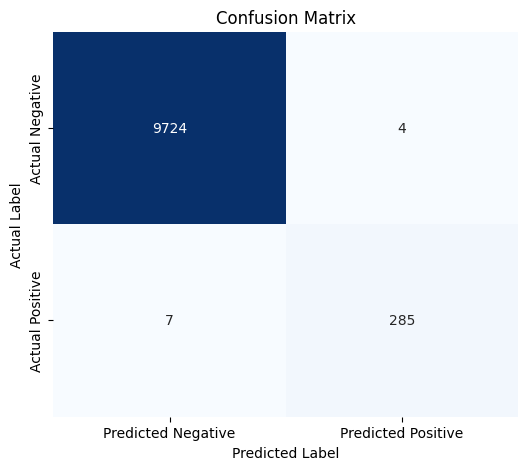

🔹 **Model 2 LR SMOTE Performance Metrics** 🔹
📊 Best threshold 0.9596
✅ Balanced Accuracy Score: 0.9874
🎯 F1 Score: 0.9677
📊 Average Precision Score: 0.9845


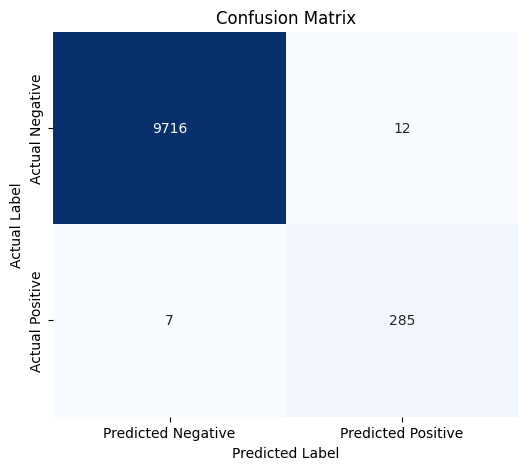

🔹 **Model 3 LR TOMEK Performance Metrics** 🔹
📊 Best threshold 0.4949
✅ Balanced Accuracy Score: 0.9878
🎯 F1 Score: 0.9794
📊 Average Precision Score: 0.9849


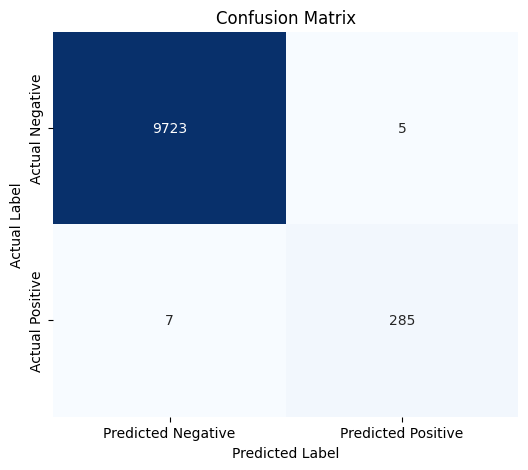

🔹 **Model 4 LR balanced Performance Metrics** 🔹
📊 Best threshold 0.9192
✅ Balanced Accuracy Score: 0.9877
🎯 F1 Score: 0.9777
📊 Average Precision Score: 0.9867


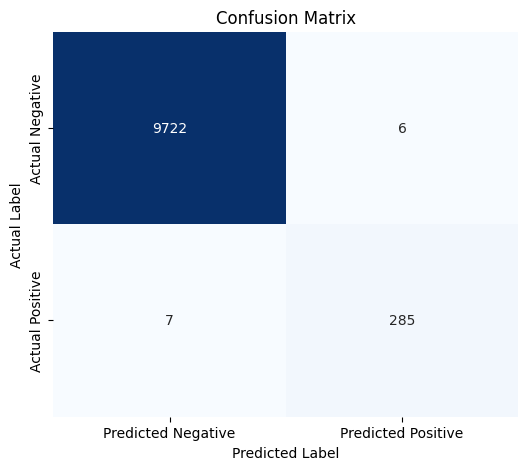

🔹 **Model 5 RF Base Performance Metrics** 🔹
📊 Best threshold 0.3030
✅ Balanced Accuracy Score: 0.9983
🎯 F1 Score: 0.9983
📊 Average Precision Score: 1.0000


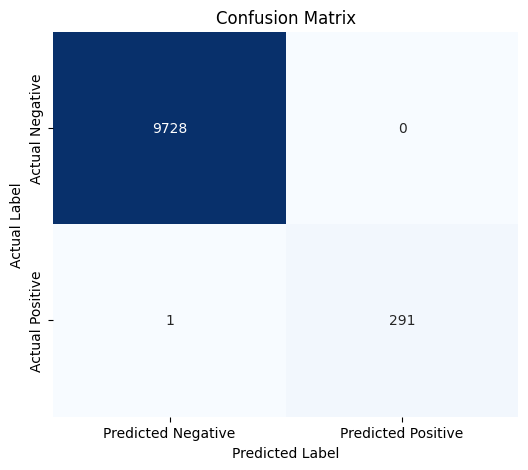

🔹 **Model 6 RF SMOTE Performance Metrics** 🔹
📊 Best threshold 0.2525
✅ Balanced Accuracy Score: 1.0000
🎯 F1 Score: 1.0000
📊 Average Precision Score: 1.0000


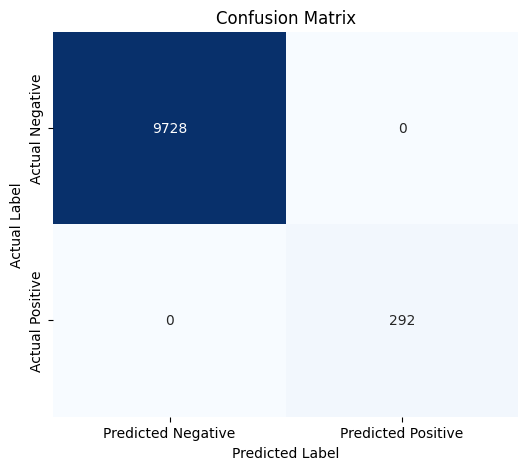

🔹 **Model 7 RF TOMEK Performance Metrics** 🔹
📊 Best threshold 0.2929
✅ Balanced Accuracy Score: 0.9983
🎯 F1 Score: 0.9983
📊 Average Precision Score: 1.0000


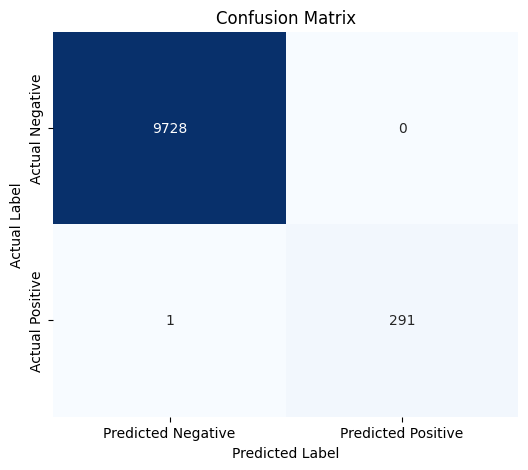

🔹 **Model 8 RF balanced Performance Metrics** 🔹
📊 Best threshold 0.2222
✅ Balanced Accuracy Score: 0.9983
🎯 F1 Score: 0.9983
📊 Average Precision Score: 1.0000


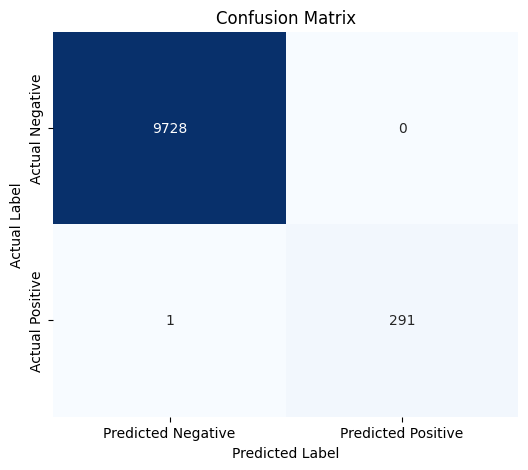

🔹 **Model 9 IF Performance Metrics** 🔹
📊 Best threshold 0.0502
✅ Balanced Accuracy Score: 0.9884
🎯 F1 Score: 0.7817
📊 Average Precision Score: 0.7742


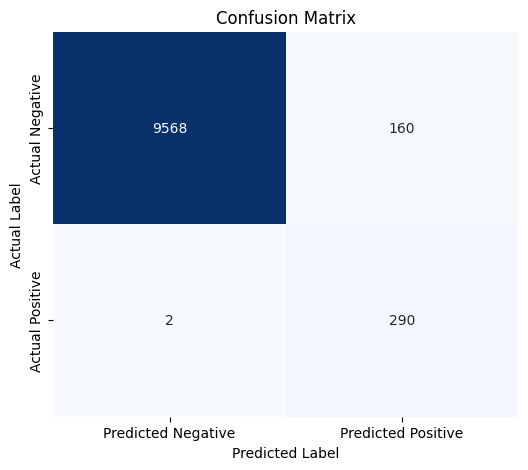

🔹 **Model 10 LOF Performance Metrics** 🔹
📊 Best threshold 1.6015
✅ Balanced Accuracy Score: 0.9800
🎯 F1 Score: 0.7776
📊 Average Precision Score: 0.5817


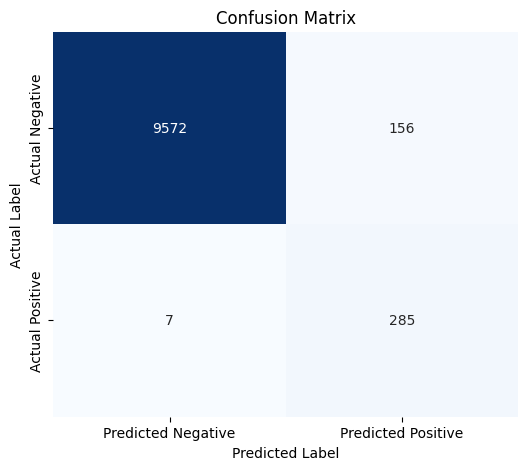

🔹 **Model 11 LR Base MinMax Performance Metrics** 🔹
📊 Best threshold 0.1818
✅ Balanced Accuracy Score: 0.9949
🎯 F1 Score: 0.9948
📊 Average Precision Score: 0.9966


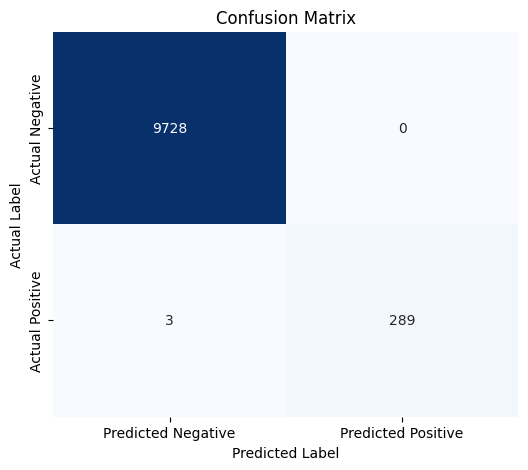

🔹 **Model 12 LR SMOTE MinMax Performance Metrics** 🔹
📊 Best threshold 0.9495
✅ Balanced Accuracy Score: 0.9965
🎯 F1 Score: 0.9949
📊 Average Precision Score: 0.9959


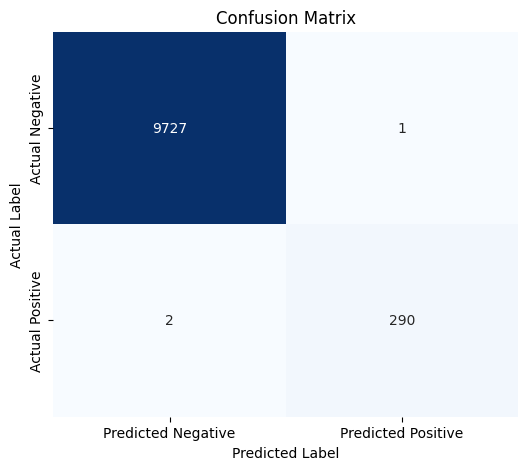

🔹 **Model 13 LR TOMEK MinMax Performance Metrics** 🔹
📊 Best threshold 0.1818
✅ Balanced Accuracy Score: 0.9949
🎯 F1 Score: 0.9948
📊 Average Precision Score: 0.9966


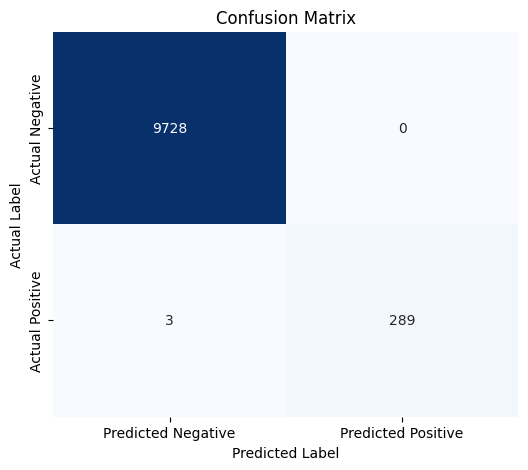

🔹 **Model 14 LR balanced MinMax Performance Metrics** 🔹
📊 Best threshold 0.9596
✅ Balanced Accuracy Score: 0.9966
🎯 F1 Score: 0.9966
📊 Average Precision Score: 0.9960


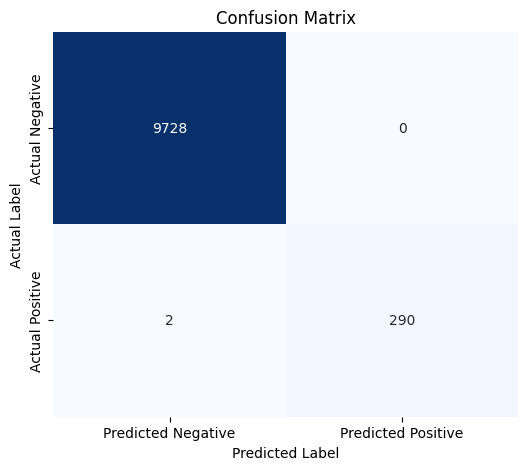

🔹 **Model 15 RF Base MinMax Performance Metrics** 🔹
📊 Best threshold 0.3030
✅ Balanced Accuracy Score: 0.9983
🎯 F1 Score: 0.9983
📊 Average Precision Score: 1.0000


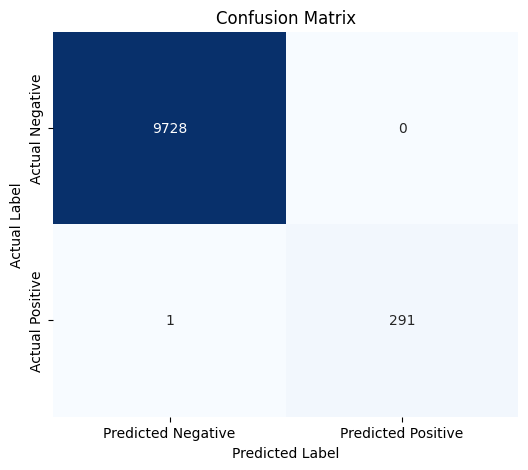

🔹 **Model 16 RF SMOTE MinMax Performance Metrics** 🔹
📊 Best threshold 0.2828
✅ Balanced Accuracy Score: 1.0000
🎯 F1 Score: 1.0000
📊 Average Precision Score: 1.0000


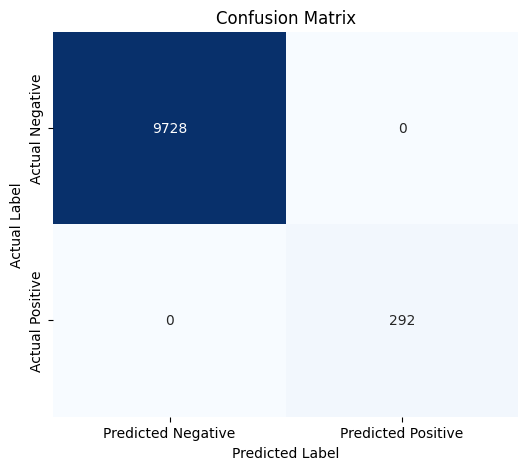

🔹 **Model 17 RF TOMEK MinMax Performance Metrics** 🔹
📊 Best threshold 0.2222
✅ Balanced Accuracy Score: 0.9999
🎯 F1 Score: 0.9983
📊 Average Precision Score: 1.0000


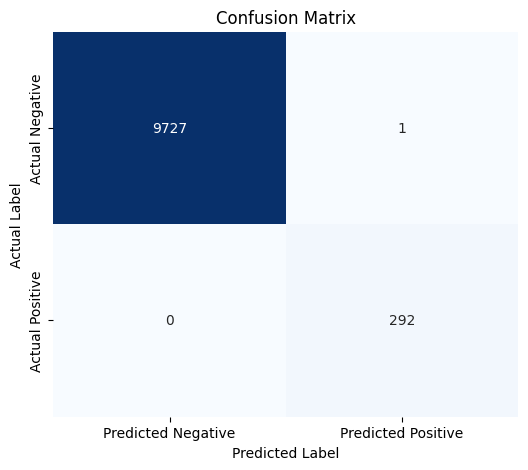

🔹 **Model 18 RF balanced MinMax Performance Metrics** 🔹
📊 Best threshold 0.2222
✅ Balanced Accuracy Score: 0.9983
🎯 F1 Score: 0.9983
📊 Average Precision Score: 1.0000


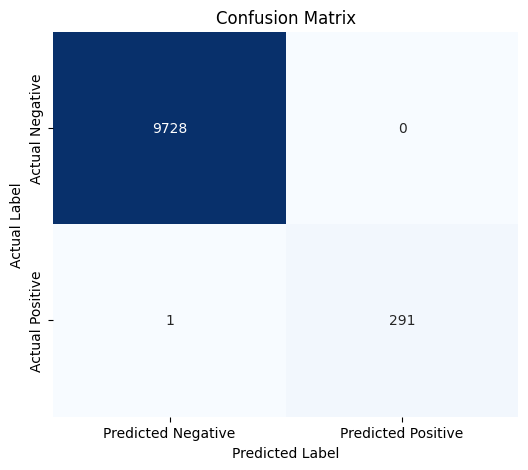

🔹 **Model 19 IF MinMax Performance Metrics** 🔹
📊 Best threshold 0.0502
✅ Balanced Accuracy Score: 0.9884
🎯 F1 Score: 0.7817
📊 Average Precision Score: 0.7742


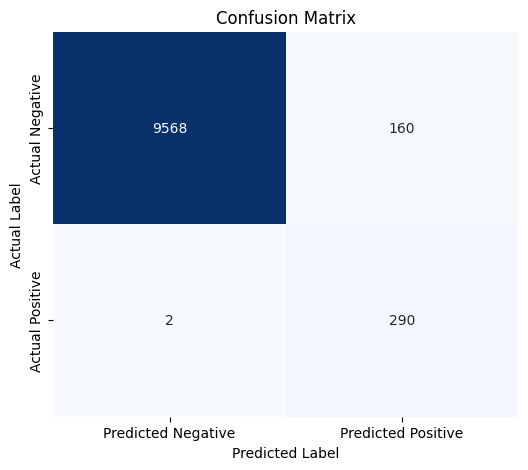

🔹 **Model 20 LOF MinMax Performance Metrics** 🔹
📊 Best threshold 0.5833
✅ Balanced Accuracy Score: 0.5004
🎯 F1 Score: 0.0567
📊 Average Precision Score: 0.3928


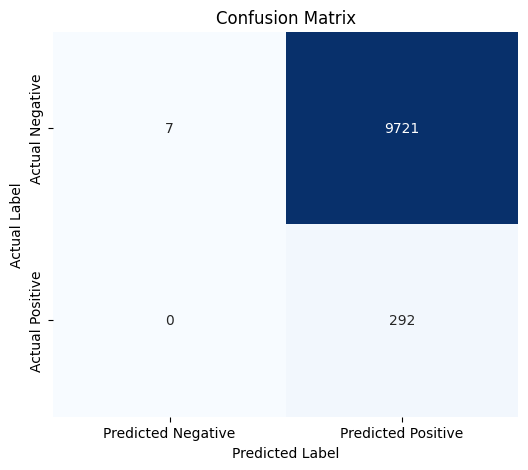

🔹 **Model 21 LR Base Robust Performance Metrics** 🔹
📊 Best threshold 0.9394
✅ Balanced Accuracy Score: 0.9880
🎯 F1 Score: 0.9879
📊 Average Precision Score: 0.9882


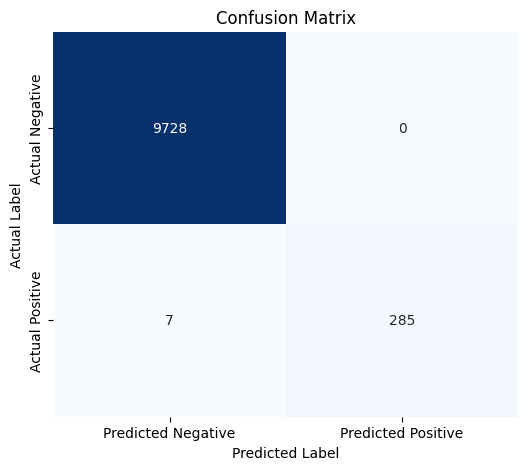

🔹 **Model 22 LR SMOTE Robust Performance Metrics** 🔹
📊 Best threshold 0.9798
✅ Balanced Accuracy Score: 0.9889
🎯 F1 Score: 0.9630
📊 Average Precision Score: 0.9757


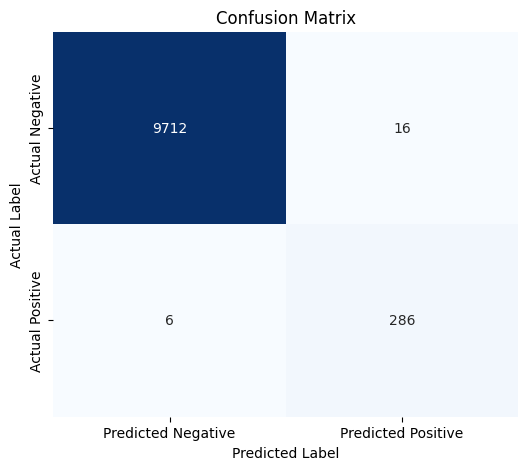

🔹 **Model 23 LR TOMEK Robust Performance Metrics** 🔹
📊 Best threshold 0.9394
✅ Balanced Accuracy Score: 0.9880
🎯 F1 Score: 0.9879
📊 Average Precision Score: 0.9876


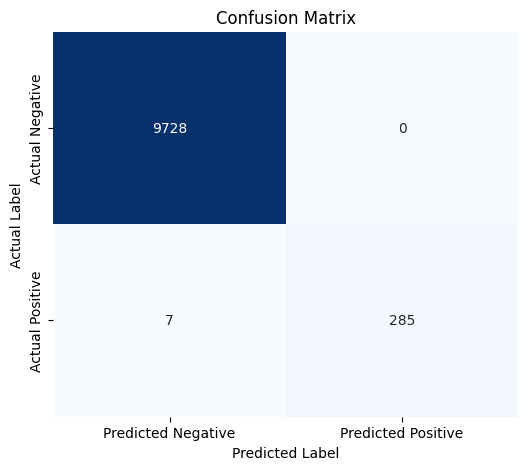

🔹 **Model 24 LR balanced Robust Performance Metrics** 🔹
📊 Best threshold 0.9394
✅ Balanced Accuracy Score: 0.9879
🎯 F1 Score: 0.9845
📊 Average Precision Score: 0.9920


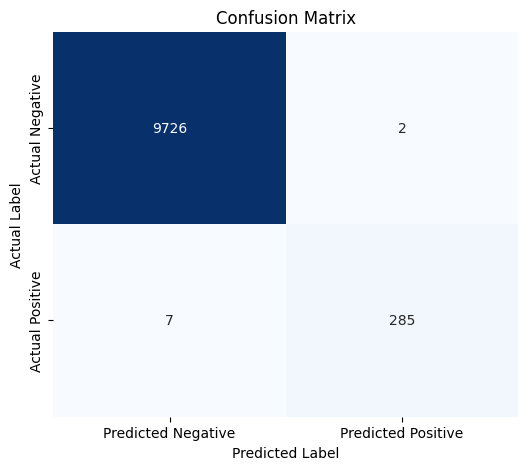

🔹 **Model 25 RF Base Robust Performance Metrics** 🔹
📊 Best threshold 0.3030
✅ Balanced Accuracy Score: 0.9983
🎯 F1 Score: 0.9983
📊 Average Precision Score: 1.0000


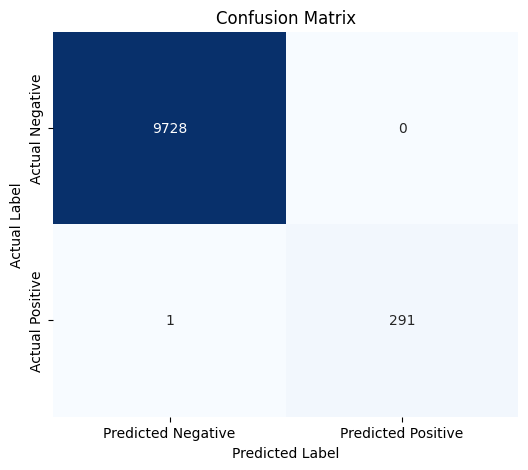

🔹 **Model 26 RF SMOTE Robust Performance Metrics** 🔹
📊 Best threshold 0.2626
✅ Balanced Accuracy Score: 1.0000
🎯 F1 Score: 1.0000
📊 Average Precision Score: 1.0000


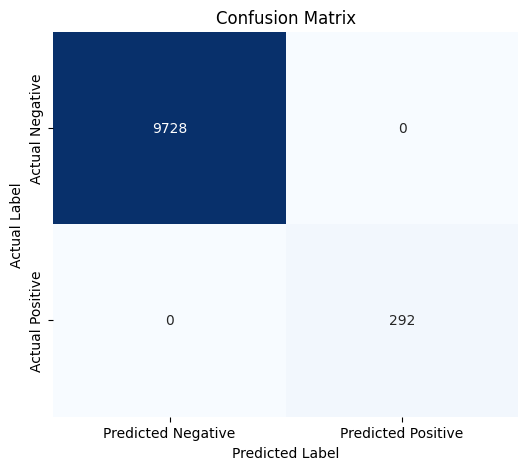

🔹 **Model 27 RF TOMEK Robust Performance Metrics** 🔹
📊 Best threshold 0.2626
✅ Balanced Accuracy Score: 0.9983
🎯 F1 Score: 0.9983
📊 Average Precision Score: 1.0000


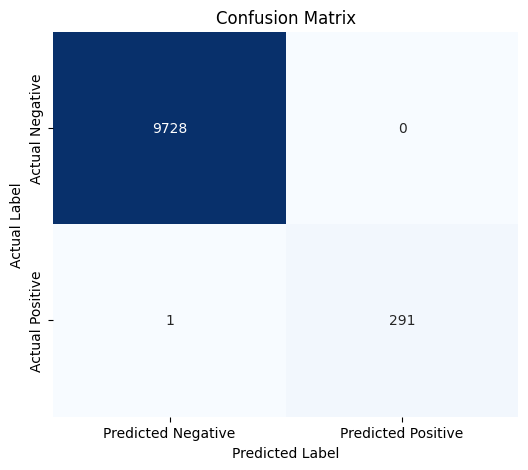

🔹 **Model 28 RF balanced Robust Performance Metrics** 🔹
📊 Best threshold 0.2222
✅ Balanced Accuracy Score: 0.9983
🎯 F1 Score: 0.9983
📊 Average Precision Score: 1.0000


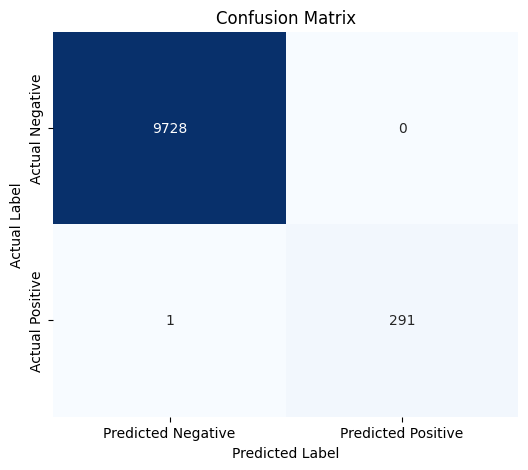

🔹 **Model 29 IF Robust Performance Metrics** 🔹
📊 Best threshold 0.0502
✅ Balanced Accuracy Score: 0.9884
🎯 F1 Score: 0.7817
📊 Average Precision Score: 0.7742


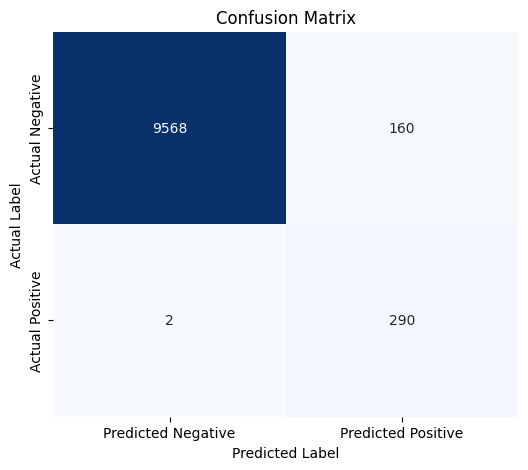

🔹 **Model 30 LOF Robust Performance Metrics** 🔹
📊 Best threshold 1.6687
✅ Balanced Accuracy Score: 0.9670
🎯 F1 Score: 0.6871
📊 Average Precision Score: 0.4747


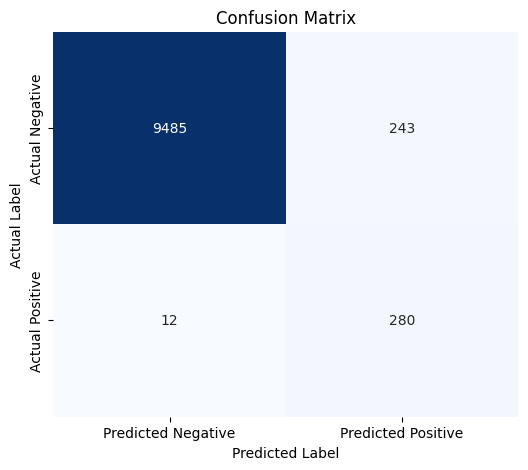

In [19]:
display_metrics(results_kdd)

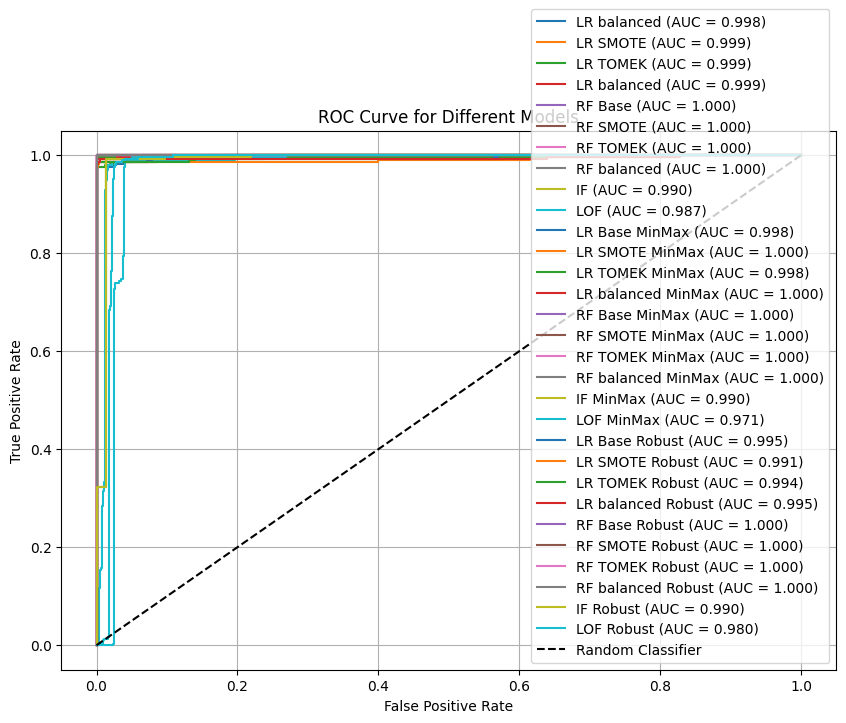

In [20]:
plot_roc_curve(results_kdd, Y_kdd_test)

In [21]:
best_key_kdd, best_strategy_kdd = get_best_strategy_by_score(results_kdd)
print(f"Meilleure stratégie : {best_strategy_kdd['name']} avec un score de {best_strategy_kdd['average_precision_score']}")

Meilleure stratégie : RF SMOTE avec un score de 1.0


In [22]:
print(best_strategy_kdd)

{'best_strategy': <objects.Strategy.Strategy object at 0x0000023A01004550>, 'name': 'RF SMOTE', 'best_threshold': 0.25252525252525254, 'confusion_matrix': array([[9728,    0],
       [   0,  292]]), 'balanced_accuracy_score': np.float64(1.0), 'f1_score': 1.0, 'average_precision_score': np.float64(1.0), 'y_prob': array([0., 0., 0., ..., 0., 0., 0.])}


In [23]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, classification_report, average_precision_score
import pickle

clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10,
                             min_samples_leaf=5, max_features='sqrt', class_weight="balanced", random_state=1)
P = Pipeline([
    ('ss', StandardScaler()),
    ('FS', SelectFromModel(clf, max_features=30)),
    ('classifier', clf)
])


In [24]:
P.fit(X_kdd_train, Y_kdd_train)
print("Pipeline entraînée avec succès !")

Pipeline entraînée avec succès !


In [ ]:
with open('../artifacts/kdd_model.pkl', "wb") as f:
    pickle.dump(P, f)


In [26]:
P.predict(X_kdd_test)

array([0, 0, 0, ..., 0, 0, 0])